In [56]:
import numpy as np
from matplotlib import pyplot as plt;
import pandas as pd
import tensorflow as tf
import time

# generate random seed with tim
np.random.seed(int(time.time()))

In [57]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [58]:
data = pd.read_csv("./train.csv")
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = np.array(data)
m = data.shape[0]
Y_tmp = data[:, 0]
X_tmp = data[:, 1:]

In [ ]:
X = X_tmp.reshape(m, int(X_tmp.shape[1] ** (0.5)), int(X_tmp.shape[1] ** (0.5)), 1)
X.shape

(42000, 28, 28, 1)

In [ ]:
Y = np.zeros((m, 10))
for i in range(len(Y_tmp)):
    Y[i, Y_tmp[i]] = 1
Y.shape

(42000, 10)

In [ ]:
# Data Augmentation (Flip on Y axis)
X = np.concatenate((X, X[:, :, ::-1, :]))
print(X.shape)
Y = np.concatenate((Y, Y))
print(Y.shape)

# our m has changed
m = X.shape[0]

(84000, 28, 28, 1)
(84000, 10)


In [ ]:
# shuffle both sets (X , Y)
perm = np.random.permutation(m)
X = X[perm, :, :, :]
Y = Y[perm, :]

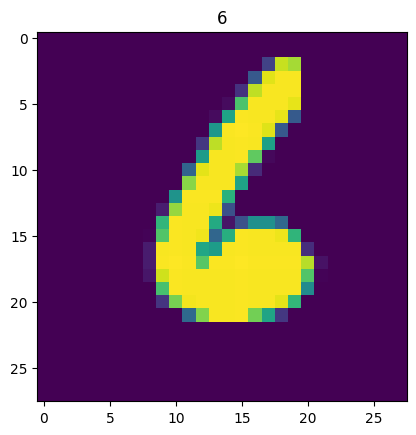

In [ ]:
# Show random image of the dataset
random_index = np.random.randint(0, Y.shape[0])
plt.imshow(X[random_index, :, :, :])
plt.title(np.argmax(Y[random_index, :]))
plt.show()

In [ ]:
# Normalize image sets
X = X / 255

In [ ]:
# Split to train and test sets
train_size = 70000

X_train = X[:train_size, :, :, :]
Y_train = Y[:train_size, :]
X_val = X[train_size:, :, :, :]
Y_val = Y[train_size:, :]

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(70000, 28, 28, 1)
(70000, 10)
(14000, 28, 28, 1)
(14000, 10)


In [ ]:
def residual_block(x, layer_props: list, type, initializer=tf.keras.initializers.glorot_uniform):
    x_shortcut = x
    props = dict()
    layer_count = len(layer_props)
    for i in range(layer_count):
        props[f"filter_count_{i}"] = (layer_props[i])[0]
        props[f"filter_{i}"] = (layer_props[i])[1]
        props[f"stride_{i}"] = (layer_props[i])[2]
        props[f"padding_{i}"] = (layer_props[i])[3]

    for i in range(layer_count - 1):
        x = tf.keras.layers.Conv2D(filters = props[f"filter_count_{i}"], kernel_size = props[f"filter_{i}"], strides = (props[f"stride_{i}"], props[f"stride_{i}"]), padding=props[f"padding_{i}"], kernel_initializer = initializer(seed=0))(x)
        x = tf.keras.layers.BatchNormalization(axis = 3)(x)
        x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = props[f"filter_count_{layer_count-1}"], kernel_size = props[f"filter_{layer_count-1}"], strides = (props[f"stride_{layer_count-1}"], props[f"stride_{layer_count-1}"]), padding=props[f"padding_{layer_count-1}"], kernel_initializer = initializer(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(axis = 3)(x)

    if type == "identity":
        pass
    elif type == "convolution":
        x_shortcut = tf.keras.layers.Conv2D(filters = props[f"filter_count_{layer_count-1}"], kernel_size = props[f"filter_{0}"], strides = (props[f"stride_{0}"], props[f"stride_{0}"]), padding=props[f"padding_{0}"], kernel_initializer = initializer(seed=0))(x_shortcut)
        x_shortcut = tf.keras.layers.BatchNormalization(axis = 3)(x_shortcut)
    else:
        raise Exception("Please enter a valid type value [identity, convolution]")

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.Activation("relu")(x)

    return x

In [ ]:
model_input = tf.keras.layers.Input(X.shape[1:])

#
model = tf.keras.layers.Conv2D(64, (9, 9), strides = (1, 1), kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0)) (model_input)
model = tf.keras.layers.MaxPooling2D((6, 6), strides=(1, 1)) (model)

#
model = residual_block(x=model, layer_props=[(64, 1, 1, "valid"), (64, 3, 1, "same"), (256, 1, 1, "valid")], type="convolution")
model = residual_block(x=model, layer_props=[(64, 1, 1, "valid"), (64, 3, 1, "same"), (256, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(64, 1, 1, "valid"), (64, 3, 1, "same"), (256, 1, 1, "valid")], type="identity")

#
model = residual_block(x=model, layer_props=[(128, 1, 2, "valid"), (128, 3, 1, "same"), (512, 1, 1, "valid")], type="convolution")
model = residual_block(x=model, layer_props=[(128, 1, 1, "valid"), (128, 3, 1, "same"), (512, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(128, 1, 1, "valid"), (128, 3, 1, "same"), (512, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(128, 1, 1, "valid"), (128, 3, 1, "same"), (512, 1, 1, "valid")], type="identity")

#
model = residual_block(x=model, layer_props=[(256, 1, 2, "valid"), (256, 3, 1, "same"), (1024, 1, 1, "valid")], type="convolution")
model = residual_block(x=model, layer_props=[(256, 1, 1, "valid"), (256, 3, 1, "same"), (1024, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(256, 1, 1, "valid"), (256, 3, 1, "same"), (1024, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(256, 1, 1, "valid"), (256, 3, 1, "same"), (1024, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(256, 1, 1, "valid"), (256, 3, 1, "same"), (1024, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(256, 1, 1, "valid"), (256, 3, 1, "same"), (1024, 1, 1, "valid")], type="identity")

#
model = residual_block(x=model, layer_props=[(512, 1, 2, "valid"), (512, 3, 1, "same"), (2048, 1, 1, "valid")], type="convolution")
model = residual_block(x=model, layer_props=[(512, 1, 1, "valid"), (512, 3, 1, "same"), (2048, 1, 1, "valid")], type="identity")
model = residual_block(x=model, layer_props=[(512, 1, 1, "valid"), (512, 3, 1, "same"), (2048, 1, 1, "valid")], type="identity")

#
model = tf.keras.layers.AveragePooling2D((2,2)) (model)

#
model = tf.keras.layers.Flatten() (model)
model = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0)) (model)

model = tf.keras.models.Model(inputs = model_input, outputs = model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_53 (Conv2D)          (None, 20, 20, 64)           5248      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)           0         ['conv2d_53[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_54 (Conv2D)          (None, 15, 15, 64)           4160      ['max_pooling2d_1[0][0]'

In [ ]:
with tf.device(device_name):
  np.random.seed(int(time.time()))
  tf.random.set_seed(int(time.time()))
  opt = tf.keras.optimizers.Adam()
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/20
2188/2188 [==============================] - 164s 61ms/step - loss: 0.3455 - accuracy: 0.9081 - val_loss: 0.1361 - val_accuracy: 0.9606
Epoch 2/20
2188/2188 [==============================] - 132s 60ms/step - loss: 0.1352 - accuracy: 0.9618 - val_loss: 0.1142 - val_accuracy: 0.9671
Epoch 3/20
2188/2188 [==============================] - 128s 58ms/step - loss: 0.1446 - accuracy: 0.9605 - val_loss: 0.1101 - val_accuracy: 0.9666
Epoch 4/20
2188/2188 [==============================] - 128s 59ms/step - loss: 0.1217 - accuracy: 0.9667 - val_loss: 0.0671 - val_accuracy: 0.9809
Epoch 5/20
2188/2188 [==============================] - 132s 60ms/step - loss: 0.0691 - accuracy: 0.9787 - val_loss: 0.0666 - val_accuracy: 0.9784
Epoch 6/20
2188/2188 [==============================] - 127s 58ms/step - loss: 0.0674 - accuracy: 0.9804 - val_loss: 0.0766 - val_accuracy: 0.9788
Epoch 7/20
2188/2188 [==============================] - 132s 60ms/step - loss: 0.0681 - accuracy: 0.9804 - val_loss: 0

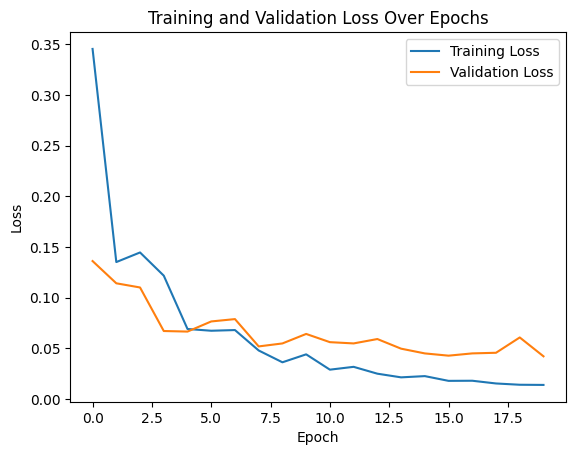

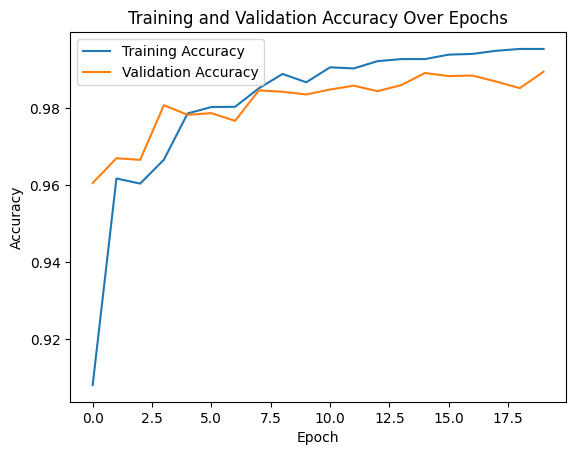

In [ ]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [59]:
data_test = pd.read_csv("test.csv")
data_test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
data_test = np.array(data_test)
m_test = data_test.shape[0]
X_tmp_test = data_test[:, :]

In [61]:
X_test = X_tmp_test.reshape(m_test, int(X_tmp_test.shape[1] ** (0.5)), int(X_tmp_test.shape[1] ** (0.5)), 1)
X_test.shape

(28000, 28, 28, 1)

In [62]:
X_test = X_test / 255

In [63]:
prediction = model.predict(X_test)
prediction.shape

875/875 [==============================] - 12s 12ms/step


(28000, 10)

In [64]:
prediction = np.argmax(prediction, axis = 1)
prediction.shape

(28000,)

In [65]:
image_ids = np.array(range(1, m_test + 1))
image_ids.shape

(28000,)

In [66]:
result = {"ImageId": image_ids, "Label": prediction}

In [67]:
result = pd.DataFrame(result)
result

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [69]:
result.to_csv('result.csv', index=False)